#### Load libraries

In [29]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


#### Load data

In [30]:
input_path = os.path.abspath(f"../../../../datasets/raw/sepsis/sepsis_raw.csv")
output_path_data = os.path.abspath(f"../../../../datasets/raw/sepsis/sepsis.csv")
output_path_labels = os.path.abspath(f"../../../../datasets/raw/sepsis/labels.csv")

df = pd.read_csv(input_path)

#### Rename columns

In [31]:
df.rename(columns={
    "org:group" : "Group",
    "concept:name" : "Activity",
    "time:timestamp" : "Timestamp",
    "case:concept:name" : "CaseID",
    "lifecycle:transition": "Lifecycle"
}, inplace=True)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 1050
(15214, 32)


#### Print all columns

In [32]:
print(list(df.columns))

['InfectionSuspected', 'Group', 'DiagnosticBlood', 'DisfuncOrg', 'SIRSCritTachypnea', 'Hypotensie', 'SIRSCritHeartRate', 'Infusion', 'DiagnosticArtAstrup', 'Activity', 'Age', 'DiagnosticIC', 'DiagnosticSputum', 'DiagnosticLiquor', 'DiagnosticOther', 'SIRSCriteria2OrMore', 'DiagnosticXthorax', 'SIRSCritTemperature', 'Timestamp', 'DiagnosticUrinaryCulture', 'SIRSCritLeucos', 'Oligurie', 'DiagnosticLacticAcid', 'Lifecycle', 'Diagnose', 'Hypoxie', 'DiagnosticUrinarySediment', 'DiagnosticECG', 'CaseID', 'Leucocytes', 'CRP', 'LacticAcid']


##### Drop missing Case IDs

In [33]:
df.dropna(subset=['CaseID'], inplace = True)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 1049
(15190, 32)


#### Extract variables: IV Liquid / IV Antibiotics / ReleaseType / Admission IC / Return ER

In [34]:
df["IV Liquid"] = df["Activity"].apply(lambda x: 1 if x == "IV Liquid" else None)
df["IV Antibiotics"] = df["Activity"].apply(lambda x: 1 if x == "IV Antibiotics" else None)
df["Admission IC"] = df["Activity"].apply(lambda x: 1 if x == "Admission IC" else None)
df["Return ER"] = df["Activity"].apply(lambda x: 1 if x == "Return ER" else None)

# Creating categorical variable ReleaseType
df["ReleaseType"] = df["Activity"].apply(lambda x: x if x in ["Release B", "Release A", "Release D", "Release C", "Release E"] else None)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 1049
(15190, 37)


#### Convert timestamp to datetime type

In [35]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Date'] = df['Timestamp'].dt.date
df.sort_values(by=["CaseID", "Timestamp"], inplace=True)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 1049
(15190, 38)


#### Drop irrelevant columns

In [36]:
df.drop(columns=[
    "Lifecycle",
    "Group",
    "Activity",
    "Diagnose",
    "Timestamp"
], inplace = True)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 1049
(15190, 33)


#### Group events by CaseID and event date

In [37]:
def custom_agg(x):
    if np.issubdtype(x.dtype, np.number):
        return x.mean()
    else:
        return x.iloc[0]

In [38]:
df = df.groupby(['CaseID', 'Date']).agg(custom_agg).reset_index()

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 1049
(4522, 33)


#### Remove sequences with less than two events

In [39]:
caseid_counts = df['CaseID'].value_counts()
df = df[df['CaseID'].isin(caseid_counts[caseid_counts >= 2].index)]
del caseid_counts

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 806
(4279, 33)


#### Extract labels

In [40]:
labels = df.groupby(["CaseID"])["Return ER"].first().fillna(0).reset_index()
labels.to_csv(output_path_labels)
df.drop(columns=["Return ER"], inplace=True)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 806
(4279, 32)


#### Set correct dtypes of columns

In [41]:
df['InfectionSuspected'] = df['InfectionSuspected'].astype('boolean')
df['DiagnosticBlood'] = df['DiagnosticBlood'].astype('boolean')
df['DisfuncOrg'] = df['DisfuncOrg'].astype('boolean')
df['SIRSCritTachypnea'] = df['SIRSCritTachypnea'].astype('boolean')
df['Hypotensie'] = df['Hypotensie'].astype('boolean')
df['SIRSCritHeartRate'] = df['SIRSCritHeartRate'].astype('boolean')
df['Infusion'] = df['Infusion'].astype('boolean')
df['DiagnosticArtAstrup'] = df['DiagnosticArtAstrup'].astype('boolean')
df['DiagnosticIC'] = df['DiagnosticIC'].astype('boolean')
df['DiagnosticSputum'] = df['DiagnosticSputum'].astype('boolean')
df['DiagnosticLiquor'] = df['DiagnosticLiquor'].astype('boolean')
df['DiagnosticOther'] = df['DiagnosticOther'].astype('boolean')
df['SIRSCriteria2OrMore'] = df['SIRSCriteria2OrMore'].astype('boolean')
df['DiagnosticXthorax'] = df['DiagnosticXthorax'].astype('boolean')
df['SIRSCritTemperature'] = df['SIRSCritTemperature'].astype('boolean')
df['DiagnosticUrinaryCulture'] = df['DiagnosticUrinaryCulture'].astype('boolean')
df['SIRSCritLeucos'] = df['SIRSCritLeucos'].astype('boolean')
df['Oligurie'] = df['Oligurie'].astype('boolean')
df['DiagnosticLacticAcid'] = df['DiagnosticLacticAcid'].astype('boolean')
df['Hypoxie'] = df['Hypoxie'].astype('boolean')
df['DiagnosticUrinarySediment'] = df['DiagnosticUrinarySediment'].astype('boolean')
df['DiagnosticECG'] = df['DiagnosticECG'].astype('boolean')
df['IV Liquid'] = df['IV Liquid'].astype('boolean')
df['IV Antibiotics'] = df['IV Antibiotics'].astype('boolean')
df['Admission IC'] = df['Admission IC'].astype('boolean')
df['IV Liquid'] = df['IV Liquid'].astype('boolean')

#### Handle missing values of booleans

In [42]:
df['InfectionSuspected'] = df.groupby('CaseID')['InfectionSuspected'].transform(lambda x: x.ffill())
df['InfectionSuspected'] = df.groupby('CaseID')['InfectionSuspected'].transform(lambda x: x.ffill())
df['DiagnosticBlood'] = df.groupby('CaseID')['DiagnosticBlood'].transform(lambda x: x.ffill())
df['DisfuncOrg'] = df.groupby('CaseID')['DisfuncOrg'].transform(lambda x: x.ffill())
df['SIRSCritTachypnea'] = df.groupby('CaseID')['SIRSCritTachypnea'].transform(lambda x: x.ffill())
df['Hypotensie'] = df.groupby('CaseID')['Hypotensie'].transform(lambda x: x.ffill())
df['SIRSCritHeartRate'] = df.groupby('CaseID')['SIRSCritHeartRate'].transform(lambda x: x.ffill())
df['Infusion'] = df.groupby('CaseID')['Infusion'].transform(lambda x: x.ffill())
df['DiagnosticArtAstrup'] = df.groupby('CaseID')['DiagnosticArtAstrup'].transform(lambda x: x.ffill())
df['DiagnosticIC'] = df.groupby('CaseID')['DiagnosticIC'].transform(lambda x: x.ffill())
df['DiagnosticSputum'] = df.groupby('CaseID')['DiagnosticSputum'].transform(lambda x: x.ffill())
df['DiagnosticLiquor'] = df.groupby('CaseID')['DiagnosticLiquor'].transform(lambda x: x.ffill())
df['DiagnosticOther'] = df.groupby('CaseID')['DiagnosticOther'].transform(lambda x: x.ffill())
df['SIRSCriteria2OrMore'] = df.groupby('CaseID')['SIRSCriteria2OrMore'].transform(lambda x: x.ffill())
df['DiagnosticXthorax'] = df.groupby('CaseID')['DiagnosticXthorax'].transform(lambda x: x.ffill())
df['SIRSCritTemperature'] = df.groupby('CaseID')['SIRSCritTemperature'].transform(lambda x: x.ffill())
df['DiagnosticUrinaryCulture'] = df.groupby('CaseID')['DiagnosticUrinaryCulture'].transform(lambda x: x.ffill())
df['SIRSCritLeucos'] = df.groupby('CaseID')['SIRSCritLeucos'].transform(lambda x: x.ffill())
df['Oligurie'] = df.groupby('CaseID')['Oligurie'].transform(lambda x: x.ffill())
df['DiagnosticLacticAcid'] = df.groupby('CaseID')['DiagnosticLacticAcid'].transform(lambda x: x.ffill())
df['Hypoxie'] = df.groupby('CaseID')['Hypoxie'].transform(lambda x: x.ffill())
df['DiagnosticUrinarySediment'] = df.groupby('CaseID')['DiagnosticUrinarySediment'].transform(lambda x: x.ffill())
df['DiagnosticECG'] = df.groupby('CaseID')['DiagnosticECG'].transform(lambda x: x.ffill())
df['IV Liquid'] = df.groupby('CaseID')['IV Liquid'].transform(lambda x: x.ffill()).fillna(False)
df['IV Antibiotics'] = df.groupby('CaseID')['IV Antibiotics'].transform(lambda x: x.ffill()).fillna(False)
df['Admission IC'] = df.groupby('CaseID')['Admission IC'].transform(lambda x: x.ffill()).fillna(False)

df['Age'] = df.groupby('CaseID')['Age'].transform(lambda x: x.ffill())
df['ReleaseType'] = df.groupby('CaseID')['ReleaseType'].transform(lambda x: x.ffill().bfill()).fillna("Release A")


print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 806
(4279, 32)


#### Remove sequences with less than no known values for CPR, Lactic Acid and Leucocytes

In [43]:
df = df[df.groupby('CaseID')['Leucocytes'].transform('any')]
df = df[df.groupby('CaseID')['CRP'].transform('any')]
df = df[df.groupby('CaseID')['LacticAcid'].transform('any')]

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 709
(3866, 32)


### Handle missing values of numericals

In [44]:
df['Leucocytes'] = df.groupby('CaseID')['Leucocytes'].transform(lambda group: group.interpolate().bfill()).round(1)
df['CRP'] = df.groupby('CaseID')['CRP'].transform(lambda group: group.interpolate().bfill()).round(1)
df['LacticAcid'] = df.groupby('CaseID')['LacticAcid'].transform(lambda group: group.interpolate().bfill()).round(1)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 709
(3866, 32)


#### Drop rows without static data

In [45]:
df.dropna(inplace=True)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 670
(3600, 32)


### Convert TimeStamps to seconds since admission

In [46]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['CaseID', 'Date'])
df['Seconds_since_first_event'] = df.groupby('CaseID')['Date'].transform(lambda x: (x - x.min()).dt.total_seconds())
df.drop(columns=["Date"], inplace=True)

#### Scale numerical data

In [47]:
numerical_cols = df.select_dtypes(include=['float64']).columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

#### Encode categorical data

In [48]:
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_categorical = encoder.fit_transform(df["ReleaseType"].to_frame())
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(["ReleaseType"]))

# Reset the indexes to prevent misalignment resulting in missing values
encoded_categorical_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

df = pd.concat([df, encoded_categorical_df], axis=1)
df.drop(columns=["ReleaseType"], inplace=True)

del encoded_categorical_df, encoded_categorical

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 670
(3600, 35)


#### Inspect sequence length distribution

    CaseID  event_count
0        A            7
2      ABA            6
4       AD            8
5      ADA            8
12      AJ           10
..     ...          ...
651    ZHA            8
652     ZI            6
654    ZJA            9
658     ZM           10
661     ZQ            6

[208 rows x 2 columns]


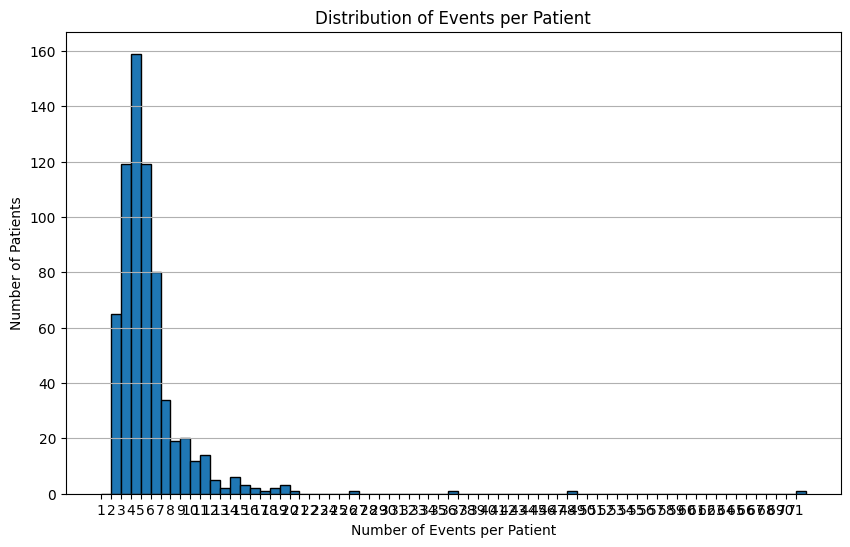

In [49]:
events_per_patient = df.groupby('CaseID').size().reset_index(name='event_count')
patients_with_more_than_4_events = events_per_patient[events_per_patient['event_count'] > 5]
print(patients_with_more_than_4_events)

# Count the number of patients with more than 4 events
num_patients_with_more_than_4_events = patients_with_more_than_4_events.shape[0]
plt.figure(figsize=(10, 6))
plt.hist(events_per_patient['event_count'], bins=range(1, events_per_patient['event_count'].max() + 2), edgecolor='black')
plt.xlabel('Number of Events per Patient')
plt.ylabel('Number of Patients')
plt.title('Distribution of Events per Patient')
plt.xticks(range(1, events_per_patient['event_count'].max() + 1))
plt.grid(axis='y')
plt.show()

del patients_with_more_than_4_events, events_per_patient

#### Select filters with at least X events

In [50]:
caseid_counts = df['CaseID'].value_counts()
df = df[df['CaseID'].isin(caseid_counts[caseid_counts >= 4].index)]
del caseid_counts

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 486
(3113, 35)


#### Select first four events per sequence

In [51]:
df = df.groupby('CaseID').head(4)

#### Inspect correlations

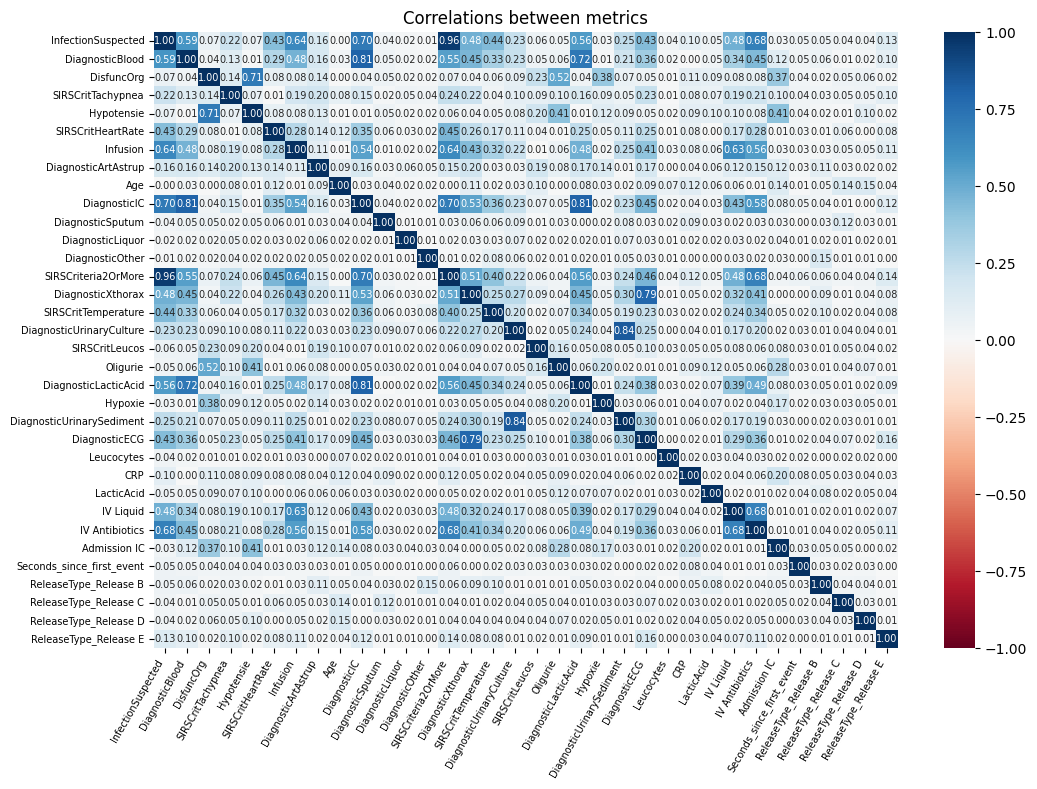

In [52]:
corrs = df.iloc[:, 1:].corr().abs()

plt.figure(figsize=(12,8), dpi = 100)
sns.heatmap(corrs, annot = True, fmt = '.2f', center = 0, vmin=-1, vmax=1, cmap="RdBu", annot_kws={"fontsize":7})
plt.title("Correlations between metrics")
plt.xticks(fontsize=7, rotation=60, horizontalalignment='right')
plt.yticks(fontsize=7)
plt.show()

del corrs

#### Inspect correlations

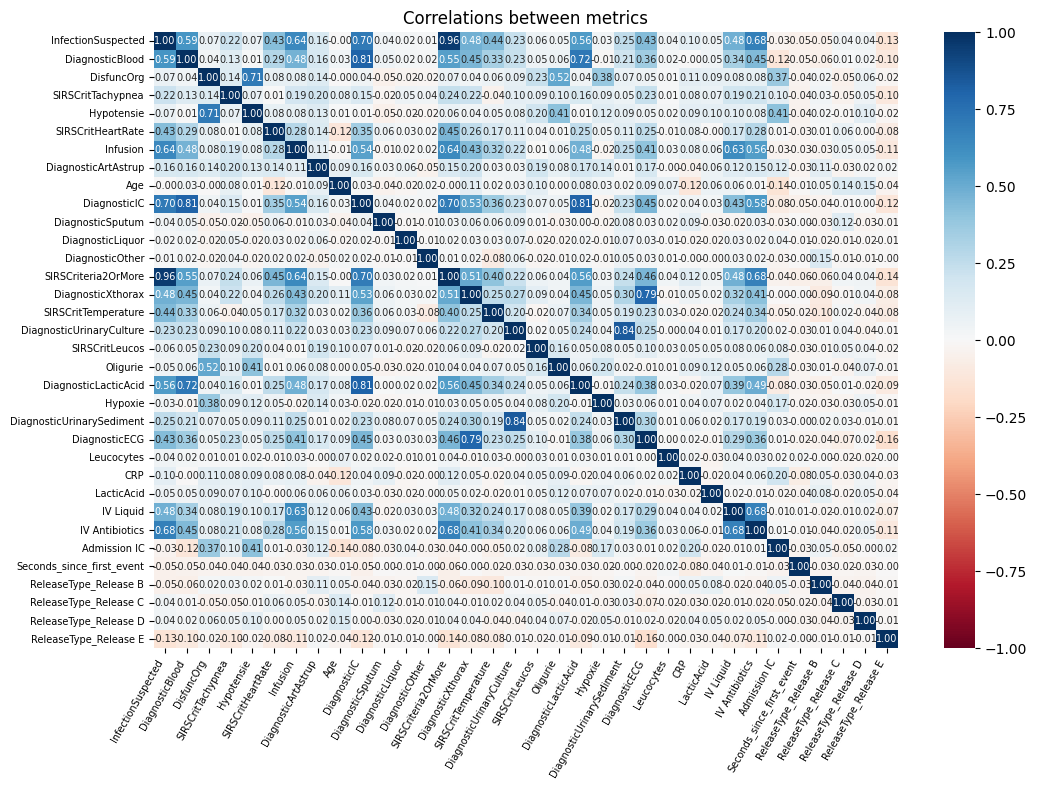

In [53]:
corrs = df.iloc[:, 1:].corr()

plt.figure(figsize=(12,8), dpi = 100)
sns.heatmap(corrs, annot = True, fmt = '.2f', center = 0, vmin=-1, vmax=1, cmap="RdBu", annot_kws={"fontsize":7})
plt.title("Correlations between metrics")
plt.xticks(fontsize=7, rotation=60, horizontalalignment='right')
plt.yticks(fontsize=7)
plt.show()

#### Remove highly correlated variables to reduce dimensionality

In [54]:
corrs = df.iloc[:, 1:].corr().abs()

threshold = 0.80
upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(to_drop)
df = df.drop(columns=to_drop)

del to_drop, upper

['DiagnosticIC', 'SIRSCriteria2OrMore', 'DiagnosticLacticAcid', 'DiagnosticUrinarySediment']


#### Reinspect Correlation matrix

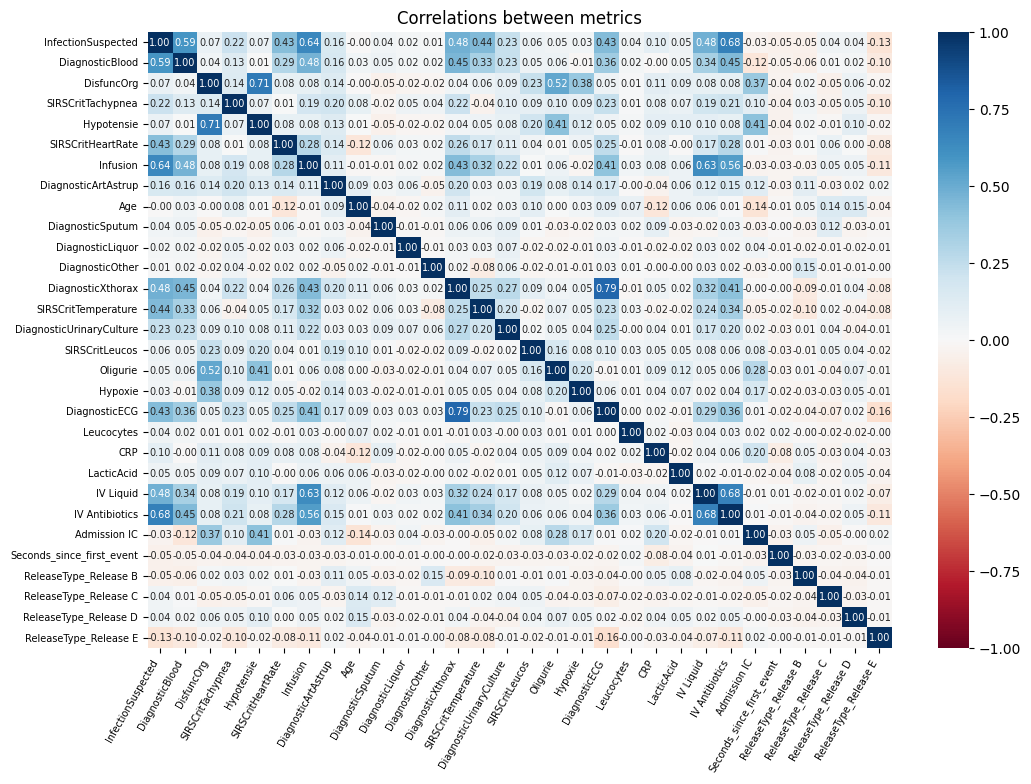

In [55]:
corrs = df.iloc[:, 1:].corr()

plt.figure(figsize=(12,8), dpi = 100)
sns.heatmap(corrs, annot = True, fmt = '.2f', center = 0, vmin=-1, vmax=1, cmap="RdBu", annot_kws={"fontsize":7})
plt.title("Correlations between metrics")
plt.xticks(fontsize=7, rotation=60, horizontalalignment='right')
plt.yticks(fontsize=7)
plt.show()

del corrs

#### Save Dataframe

In [56]:
df.to_csv(output_path_data)

print(f"Number of patients: {len(pd.unique(df["CaseID"].values))}")
print(df.shape)

Number of patients: 486
(1944, 31)
